In [115]:
import argparse
from copy import deepcopy
import logging
import os
import pprint

import torch
from torch import nn
import torch.backends.cudnn as cudnn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

from dataset.semi import SemiDataset
from model.semseg.dpt import DPT
from supervised import evaluate
from util.classes import CLASSES
from util.ohem import ProbOhemCrossEntropy2d
from util.utils import count_params, init_log, AverageMeter
from util.dist_helper import setup_distributed

In [3]:
def show_images(tensor):
    """
    Displays images from a 4D Tensor (batch_size, channels, x, y).
    
    Args:
    tensor (torch.Tensor): A tensor containing image data.
    """
    # Check if the tensor requires normalization
    if tensor.min() < 0 or tensor.max() > 1:
        # Normalize tensor to the range [0, 1]
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    
    batch_size = tensor.size(0)
    fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 3, 3))
    
    for i, img in enumerate(tensor):
        # Check the number of channels in the image
        if img.shape[0] == 3:
            # Convert from (channels, x, y) to (x, y, channels) for RGB images
            img = img.permute(1, 2, 0)
        elif img.shape[0] == 1:
            # Squeeze channel dimension for grayscale images
            img = img.squeeze(0)
        else:
            raise ValueError("Tensor contains images with unsupported channel size.")
        
        # Handle subplots for a batch size of 1
        ax = axs[i] if batch_size > 1 else axs
        ax.imshow(img)
        ax.axis('off')  # Hide axes ticks
    
    plt.show()

In [4]:
dataset = 'ade20k'
method = 'unimatch_v2'
exp = 'dinov2_small'
split = '1_2'
port = '8080'

# Constructing file paths
config = f'configs/{dataset}.yaml'
labeled_id_path = f'splits/{dataset}/{split}/labeled.txt'
unlabeled_id_path = f'splits/{dataset}/{split}/unlabeled.txt'
save_path = f'exp/{dataset}/{method}/{exp}/{split}'


In [31]:

cfg = yaml.load(open(config, "r"), Loader=yaml.Loader)

# logger = init_log('global', logging.INFO)
# logger.propagate = 0

# rank, world_size = setup_distributed(port=port)

# if rank == 0:
#     all_args = {**cfg, **vars(args), 'ngpus': world_size}
#     logger.info('{}\n'.format(pprint.pformat(all_args)))
    
#     writer = SummaryWriter(args.save_path)
    
#     os.makedirs(args.save_path, exist_ok=True)

cudnn.enabled = True
cudnn.benchmark = True

model_configs = {
    'small': {'encoder_size': 'small', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'base': {'encoder_size': 'base', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'large': {'encoder_size': 'large', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'giant': {'encoder_size': 'giant', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

model = DPT(**{**model_configs[cfg['backbone'].split('_')[-1]], 'nclass': cfg['nclass']}).cuda()
state_dict = torch.load(f'./pretrained/{cfg["backbone"]}.pth')
# model.backbone.load_state_dict(state_dict)

total_state_dict = torch.load('./pretrained/ade20k_unimatch_v2_1_32labels_dinov2_small.pth')
model.load_state_dict(total_state_dict)

if cfg['lock_backbone']:
    model.lock_backbone()

/tmp/ipykernel_22286/3316540926.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'./pretrained/{cfg["backbone"]}.pth')
/tmp/ipykernel_22286/3316

In [32]:
model_ema = deepcopy(model).cuda()
model_ema.eval()
for param in model_ema.parameters():
    param.requires_grad = False

if cfg['criterion']['name'] == 'CELoss':
    criterion_l = nn.CrossEntropyLoss(**cfg['criterion']['kwargs'])
elif cfg['criterion']['name'] == 'OHEM':
    criterion_l = ProbOhemCrossEntropy2d(**cfg['criterion']['kwargs'])
else:
    raise NotImplementedError('%s criterion is not implemented' % cfg['criterion']['name'])

criterion_u = nn.CrossEntropyLoss(reduction='none')

trainset_u = SemiDataset(
    cfg['dataset'], cfg['data_root'], 'train_u', cfg['crop_size'], unlabeled_id_path
)
trainset_l = SemiDataset(
    cfg['dataset'], cfg['data_root'], 'train_l', cfg['crop_size'], labeled_id_path, nsample=len(trainset_u.ids)
)
valset = SemiDataset(
    cfg['dataset'], cfg['data_root'], 'val'
)

In [33]:
# trainsampler_l = torch.utils.data.distributed.DistributedSampler(trainset_l)

trainloader_l = DataLoader(
    trainset_l, batch_size=cfg['batch_size'], pin_memory=True, num_workers=4, drop_last=True, shuffle=False)

# trainsampler_u = torch.utils.data.distributed.DistributedSampler(trainset_u)

trainloader_u = DataLoader(
    trainset_u, batch_size=cfg['batch_size'], pin_memory=True, num_workers=4, drop_last=True, shuffle=False)

# valsampler = torch.utils.data.distributed.DistributedSampler(valset)

valloader = DataLoader(
    valset, batch_size=1, pin_memory=True, num_workers=1, drop_last=False, shuffle=False)

total_iters = len(trainloader_u) * cfg['epochs']
previous_best, previous_best_ema = 0.0, 0.0
best_epoch, best_epoch_ema = 0, 0
epoch = -1


In [34]:
loader = zip(trainloader_l, trainloader_u)

In [35]:
model.eval()

DPT(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        

In [36]:
loader_enumerator = iter(loader)


In [52]:
# for i, ((img_x, mask_x),(img_u_w, img_u_s1, img_u_s2, ignore_mask, cutmix_box1, cutmix_box2)) in enumerate(loader):
((img_x, mask_x),(img_u_w, img_u_s1, img_u_s2, ignore_mask, cutmix_box1, cutmix_box2)) = next(loader_enumerator)

img_x, mask_x = img_x.cuda(), mask_x.cuda()
img_u_w, img_u_s1, img_u_s2 = img_u_w.cuda(), img_u_s1.cuda(), img_u_s2.cuda()
ignore_mask, cutmix_box1, cutmix_box2 = ignore_mask.cuda(), cutmix_box1.cuda(), cutmix_box2.cuda()

with torch.no_grad():
    pred_u_w = model_ema(img_u_w).detach()
    conf_u_w = pred_u_w.softmax(dim=1).max(dim=1)[0]
    mask_u_w = pred_u_w.argmax(dim=1)

img_u_s1[cutmix_box1.unsqueeze(1).expand(img_u_s1.shape) == 1] = img_u_s1.flip(0)[cutmix_box1.unsqueeze(1).expand(img_u_s1.shape) == 1]
img_u_s2[cutmix_box2.unsqueeze(1).expand(img_u_s2.shape) == 1] = img_u_s2.flip(0)[cutmix_box2.unsqueeze(1).expand(img_u_s2.shape) == 1]

pred_x = model(img_x)
pred_u_s1, pred_u_s2 = model(torch.cat((img_u_s1, img_u_s2)), comp_drop=True).chunk(2)

mask_u_w_cutmixed1, conf_u_w_cutmixed1, ignore_mask_cutmixed1 = mask_u_w.clone(), conf_u_w.clone(), ignore_mask.clone()
mask_u_w_cutmixed2, conf_u_w_cutmixed2, ignore_mask_cutmixed2 = mask_u_w.clone(), conf_u_w.clone(), ignore_mask.clone()

mask_u_w_cutmixed1[cutmix_box1 == 1] = mask_u_w.flip(0)[cutmix_box1 == 1]
conf_u_w_cutmixed1[cutmix_box1 == 1] = conf_u_w.flip(0)[cutmix_box1 == 1]
ignore_mask_cutmixed1[cutmix_box1 == 1] = ignore_mask.flip(0)[cutmix_box1 == 1]

mask_u_w_cutmixed2[cutmix_box2 == 1] = mask_u_w.flip(0)[cutmix_box2 == 1]
conf_u_w_cutmixed2[cutmix_box2 == 1] = conf_u_w.flip(0)[cutmix_box2 == 1]
ignore_mask_cutmixed2[cutmix_box2 == 1] = ignore_mask.flip(0)[cutmix_box2 == 1]

loss_x = criterion_l(pred_x, mask_x)

loss_u_s1 = criterion_u(pred_u_s1, mask_u_w_cutmixed1)
loss_u_s1 = loss_u_s1 * ((conf_u_w_cutmixed1 >= cfg['conf_thresh']) & (ignore_mask_cutmixed1 != 255))
loss_u_s1 = loss_u_s1.sum() / (ignore_mask_cutmixed1 != 255).sum().item()

loss_u_s2 = criterion_u(pred_u_s2, mask_u_w_cutmixed2)
loss_u_s2 = loss_u_s2 * ((conf_u_w_cutmixed2 >= cfg['conf_thresh']) & (ignore_mask_cutmixed2 != 255))
loss_u_s2 = loss_u_s2.sum() / (ignore_mask_cutmixed2 != 255).sum().item()

loss_u_s = (loss_u_s1 + loss_u_s2) / 2.0

loss = (loss_x + loss_u_s) / 2.0
    
    # break

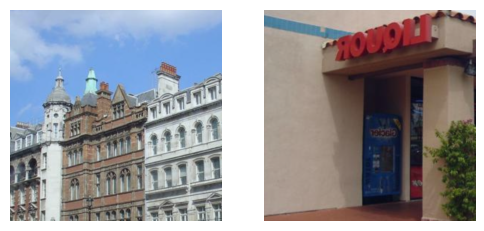

In [53]:
show_images(img_x.cpu())

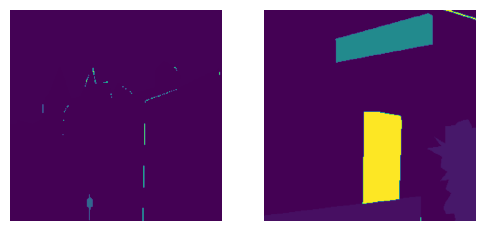

In [54]:
show_images(mask_x.cpu().unsqueeze(1))

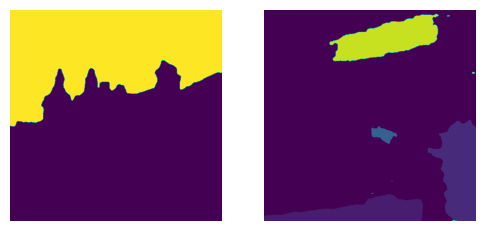

In [135]:
show_images(pred_x_noisy_latent.argmax(1).detach().cpu().unsqueeze(1))

In [88]:
img_x.size()

torch.Size([2, 3, 518, 518])

In [134]:
latent = model.backbone.get_intermediate_layers(
            img_x, model.intermediate_layer_idx[model.encoder_size]
        )


# latent = model.backbone(img_x)
noise = np.random.normal(0, 3, latent[0].shape) 
noisy_latent = []
for latent_i in latent:
    noisy_latent.append(torch.tensor(latent_i.cpu() + np.float32(noise)).cuda())

noisy_latent = tuple(noisy_latent)
# noisy_latent = torch.tensor(noisy_latent).cuda()

patch_h, patch_w = img_x.shape[-2] // 14, img_x.shape[-1] // 14

pred_x_noisy_latent = model.head(noisy_latent, patch_h, patch_w)
pred_x_noisy_latent = F.interpolate(pred_x_noisy_latent, (patch_h * 14, patch_w * 14), mode='bilinear', align_corners=True)

/tmp/ipykernel_22286/527720122.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_latent.append(torch.tensor(latent_i.cpu() + np.float32(noise)).cuda())


In [122]:
latent[0].dtype

torch.float32

In [120]:
len(noisy_latent)

4

In [85]:
noise.shape

(2, 1369, 384)

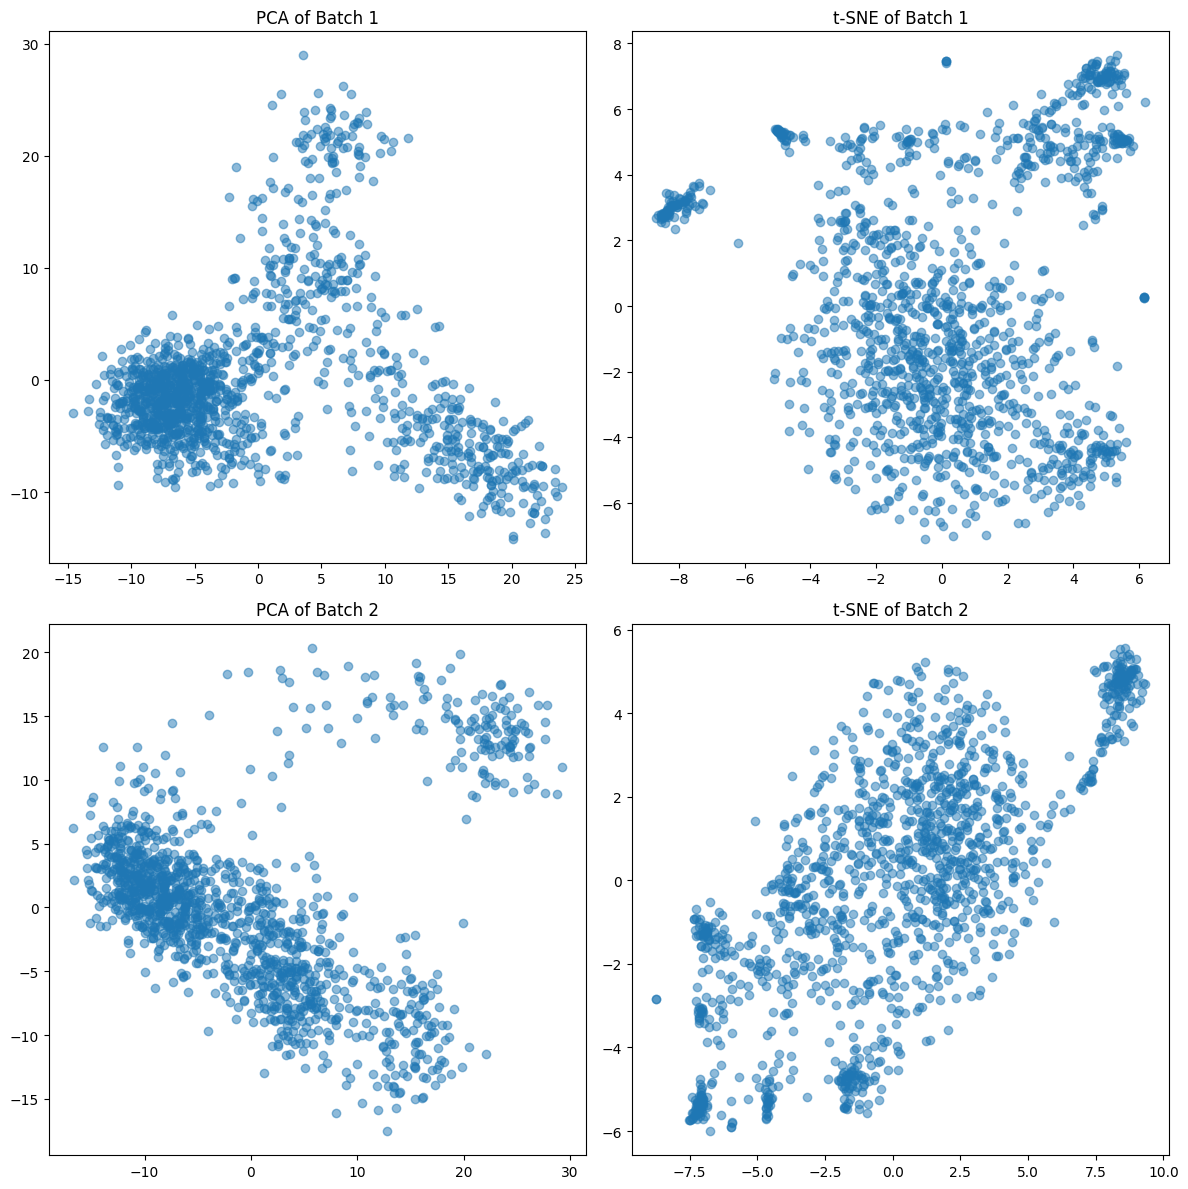

In [86]:
# Iterate over each batch
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # Prepare a subplot grid
batch_titles = ['Batch 1', 'Batch 2']  # Titles for each subplot

for i, batch_data in enumerate(noisy_latent):
    # Flatten each batch data to [1369, 384]
    latent_flat = batch_data.cpu().view(-1, 384)

    # PCA
    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_flat.numpy())

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    latent_tsne = tsne.fit_transform(latent_flat.numpy())

    # Plot PCA
    ax = axes[i, 0]
    ax.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.5)
    ax.set_title(f'PCA of {batch_titles[i]}')

    # Plot t-SNE
    ax = axes[i, 1]
    ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], alpha=0.5)
    ax.set_title(f't-SNE of {batch_titles[i]}')

plt.tight_layout()
plt.show()